## Getting Started with pyDelta's _next_ branch

pyDelta's _next_ branch contains our work-in-progress implementation of experiments using Delta variants as a python library. We assume you have installed the library using `pip`.

First, let's import the delta package:

In [2]:
import delta

KMedoids clustering not available.
You need a patched scikit-learn, see README.txt
Traceback (most recent call last):
  File "/home/tv/git/pydelta.2015/delta/cluster.py", line 235, in <module>
    from sklearn.cluster import KMedoids
ImportError: cannot import name 'KMedoids'
/home/tv/git/pydelta.2015/delta/__init__.py:33: UserWarning: KMedoidsClustering not available
  warn("KMedoidsClustering not available")


Support for PAM / k-medoids clustering is planned to be included into scikit-learn, however it is only available in a preliminary form on a specific branch yet. Pydelta will still work without PAM support using the default hierarchical _ward_ clustering.

### Loading the corpus and preparing the feature matrix

The [Corpus](delta.html#delta.corpus.Corpus) class represents the corpus as a bag-of-words feature matrix. In its simplest form, you can just call `Corpus` and pass it the directory your texts reside in:

In [3]:
raw_corpus = delta.Corpus('../../refcor/German')

This simple form assumes your texts in plain text files following the pattern `Author_Title.txt`. The reference corpora of English, French and German novels we use [can be found on Github](https://github.com/cophi-wue/refcor). If your corpus looks different, or if you need other ways of feature extraction than our simple tokenizer regular expression, have a look at the full documentation of our Corpus class for ways of parametrizing or further customizing feature extraction.

`Corpus` is simply a subclass of pandas' DataFrame. The rows represent the documents, the columns the individual types. Let's look at the Corpus' top left corner:

In [4]:
print(raw_corpus.shape)
raw_corpus.iloc[0:5,0:10]

(75, 255358)


,und,die,der,zu,in,er,den,sie,ich,nicht
"Arnim,-Ludwig-Achim-von_Armut Reichtum Schuld und Busse der Graefin Dolores",3691.0,3514.0,3421.0,1901.0,2226.0,2511.0,1444.0,2496.0,1170.0,1144.0
"Arnim,-Ludwig-Achim-von_Isabella von Aegypten",1163.0,934.0,953.0,550.0,634.0,705.0,494.0,911.0,245.0,387.0
"Arnim,-Ludwig-Achim-von_Kronenwaechter 1",2749.0,2494.0,2619.0,1309.0,1362.0,1815.0,1259.0,1306.0,699.0,844.0
"Dohm,-Hedwig_Christa Ruland",1311.0,1494.0,1115.0,744.0,942.0,550.0,659.0,1301.0,671.0,780.0
"Dohm,-Hedwig_Schicksale einer Seele",2196.0,2037.0,1589.0,931.0,1418.0,695.0,797.0,929.0,2051.0,1137.0


The matrix contains the absolute frequencies of each word in each document, columns are sorted by the sum of all absolute frequencies.

Corpus has a few methods to manipulate the feature matrix, e.g., to perform culling: To remove all tokens that are not present in at least ⅓ of all documents, use

In [5]:
culled_corpus = raw_corpus.cull(1/3)
print(culled_corpus.shape)

(75, 11011)


Unless documented otherwise, these method return a new modified corpus instead of changing the current one.


For most experiments, you'll want to work on [the relative frequencies](delta.html#corpus.Corpus.relative_frequencies) of [the $n$ most frequent words](delta.html#corpus.Corpus.topn). There is a  [combined method](delta.html#corpus.Corpus.get_mfw_table) for that:

In [6]:
c2500 = raw_corpus.get_mfw_table(2500)

### Using delta functions to create a distance matrix

pydelta provides a number of delta functions by name that all produce a [distance matrix](delta.html#deltas.DistanceMatrix). To run, e.g., Cosine Delta on our corpus from above:

In [7]:
distances = delta.functions.cosine_delta(c2500)
distances.iloc[:5,:5]

,"Arnim,-Ludwig-Achim-von_Armut Reichtum Schuld und Busse der Graefin Dolores","Arnim,-Ludwig-Achim-von_Isabella von Aegypten","Arnim,-Ludwig-Achim-von_Kronenwaechter 1","Dohm,-Hedwig_Christa Ruland","Dohm,-Hedwig_Schicksale einer Seele"
"Arnim,-Ludwig-Achim-von_Armut Reichtum Schuld und Busse der Graefin Dolores",0.000000,0.644430,0.631107,1.058730,1.010352
"Arnim,-Ludwig-Achim-von_Isabella von Aegypten",0.644430,0.000000,0.626108,1.061473,1.024089
"Arnim,-Ludwig-Achim-von_Kronenwaechter 1",0.631107,0.626108,0.000000,1.066369,1.071329
"Dohm,-Hedwig_Christa Ruland",1.058730,1.061473,1.066369,0.000000,0.515765
"Dohm,-Hedwig_Schicksale einer Seele",1.010352,1.024089,1.071329,0.515765,0.000000


It is possible to run a few evaluations already on the distance matrix:

In [7]:
distances.evaluate()

F-Ratio         0.335886
Fisher's LD     2.262457
Simple Score    3.857334
dtype: float64

F-Ratio and Fisher's Linear Discriminant are established measures (see Heeringa et al., 2008), to calculate the _Simple Score_ we first standardize the distances and then calculate the difference between the mean distances between out-group and in-group texts (i.e., texts by different authors and texts by the same author).

### Clustering results

It is common to use _clustering_ on the basis of the distance matrix in order to group similar texts. pydeltas [Clustering](delta.rst#cluster.Clustering) class is a convenience wrapper around hierarchical clustering methods, of which _Ward clustering_ is the default:

In [8]:
clustering = delta.Clustering(distances)

A hierarchical clustering is typically visualized using a _Dendrogram_. We've [included an implementation](delta.html#graph.Dendrogram) that colors by author and provides labels using the [DocumentDescriber](delta.html#corpus.DocumentDescriber) that is assigned when creating the corpus:

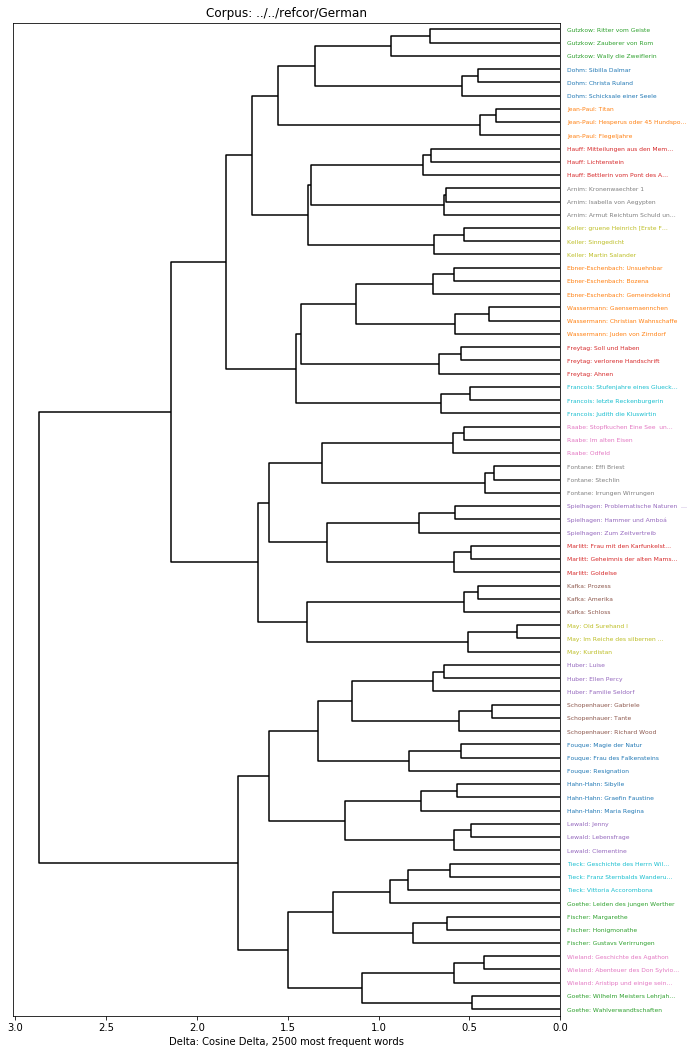

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
delta.Dendrogram(clustering).show()

For any but a visual inspection, it is probably best to cut through the hierarchical clustering to provide flat clusters. This can be done with default settings from the hierarchical clustering:

In [10]:
clusters = clustering.fclustering()
print(clusters.describe())

25 clusters of 75 documents (ground truth: 25 groups):
{1: ['Goethe: Wahlverwandtschaften', 'Goethe: Wilhelm Meisters Lehrjah…'],
 2: ['Wieland: Aristipp und einige sein…', 'Wieland: Abenteuer des Don Sylvio…',
     'Wieland: Geschichte des Agathon'],
 3: ['Fischer: Honigmonathe', 'Fischer: Gustavs Verirrungen',
     'Fischer: Margarethe'],
 4: ['Goethe: Leiden des jungen Werther', 'Tieck: Franz Sternbalds Wanderu…',
     'Tieck: Geschichte des Herrn Wil…', 'Tieck: Vittoria Accorombona'],
 5: ['Lewald: Clementine', 'Lewald: Lebensfrage', 'Lewald: Jenny'],
 6: ['Hahn-Hahn: Graefin Faustine', 'Hahn-Hahn: Maria Regina',
     'Hahn-Hahn: Sibylle'],
 7: ['Fouque: Frau des Falkensteins', 'Fouque: Magie der Natur',
     'Fouque: Resignation'],
 8: ['Schopenhauer: Tante', 'Schopenhauer: Gabriele',
     'Schopenhauer: Richard Wood'],
 9: ['Huber: Familie Seldorf', 'Huber: Ellen Percy', 'Huber: Luise'],
 10: ['May: Im Reiche des silbernen …', 'May: Kurdistan',
      'May: Old Surehand I'],
 11: 

There are also some measures of cluster quality built into [our class](delta.rst#cluster.FlatClustering):

In [11]:
clusters.evaluate()

Cluster Errors         1.000000
Adjusted Rand Index    0.965961
Homogeneity            0.990683
Completeness           0.992079
V Measure              0.991380
Purity                 0.986667
Entropy                0.009317
dtype: float64